In [1]:
# load dataframe
# load datasets
# initialize dataset class
# initialize model class

In [2]:
import pandas as pd
import numpy as np
import argparse
import yaml
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.utils.data import DataLoader

from src.data.ncf import NCFDataset
from src.models.ncf import NCFModel

from src.models.ncf import SimpleNCF, DeepNCF
from src.training.eval import collect_user_predictions, compute_metrics
from src.training.train_mlp import train_model, evaluate_model
from src.data.datasets import PointwiseImplicitDataset, OfflineImplicitDataset
from src.utils.hparam_search import param_comb
from src.data.samplers import GlobalUniformNegativeSampler

In [3]:
def load_config(path):
    with open(path, "r") as f:
        return yaml.safe_load(f)

In [4]:
from src.utils.constants import (
    DEFAULT_USER_COL as USER,
    DEFAULT_ITEM_COL as ITEM,
    DEFAULT_TARGET_COL as TARGET,
    DEFAULT_TIMESTAMP_COL as TIMESTAMP,
)

MODEL_TYPE = "DeepNCF"
TUNE = False
CONFIG = load_config("src/config/ncf.yml")

DEVICE = CONFIG["system"]["device"]
LOCATION = CONFIG["data"]["location"]
if TUNE:
    MODEL_CONFIG = CONFIG[MODEL_TYPE]["tuning"]
    TRAIN_FILE = "train"
    TEST_FILE = "val"
else:
    MODEL_CONFIG = CONFIG[MODEL_TYPE]["optim_params"]
    TRAIN_FILE = "train_val"
    TEST_FILE = "test"

In [5]:
data = NCFDataset(
    train_file_path=f"{LOCATION}/{TRAIN_FILE}.parquet",
    test_file_path=f"{LOCATION}/{TEST_FILE}.parquet",
    full_file_path=f"{LOCATION}/interactions.parquet",
)

In [6]:
data.train_dataset()

vebose: {'epochs': 1, 'learning_rate': 0.0005, 'batch_size': 128, 'n_workers': 2, 'layers': [64, 32, 16], 'dropout': 0.2, 'step_size': 3, 'gamma': 0.7, 'log_every': 20, 'threshold': 0.5, 'n_negatives': 4}
Epoch: 0 | Step: 20 | Loss: 0.22293158292770385
Epoch: 0 | Step: 40 | Loss: 0.18775847911834717
Epoch: 0 | Step: 60 | Loss: 0.18047140777111054
Epoch: 0 | Step: 80 | Loss: 0.17833563983440398
Epoch: 0 | Step: 100 | Loss: 0.17553786635398866
Epoch: 0 | Step: 120 | Loss: 0.17541186273097992
Epoch: 0 | Step: 140 | Loss: 0.17434931337833404
Epoch: 0 | Step: 160 | Loss: 0.17242037653923034
Epoch: 0 | Step: 180 | Loss: 0.1708955931663513
Epoch: 0 | Step: 200 | Loss: 0.1683027994632721
Epoch: 0 | Step: 220 | Loss: 0.16718841791152955
Epoch: 0 | Step: 240 | Loss: 0.16636474967002868
Epoch: 0 | Step: 260 | Loss: 0.16738379180431365
Epoch: 0 | Step: 280 | Loss: 0.16593790352344512
Epoch: 0 | Step: 300 | Loss: 0.16347312271595002
Epoch: 0 | Step: 320 | Loss: 0.16425782859325408
Epoch: 0 | Step: 

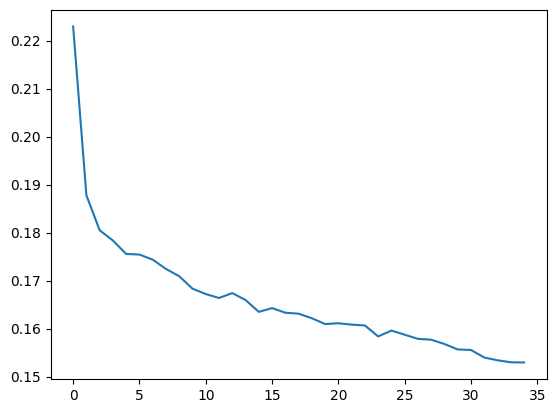

Train Loss: 0.1529



/Users/aeura/Local/Repositories/Mine/recommender-systems-playground/.venv/lib/python3.12/site-packages/torch/nn/modules/loss.py:634: UserWarning: Using a target size (torch.Size([128])) that is different to the input size (torch.Size([128, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/aeura/Local/Repositories/Mine/recommender-systems-playground/.venv/lib/python3.12/site-packages/torch/nn/modules/loss.py:634: UserWarning: Using a target size (torch.Size([116])) that is different to the input size (torch.Size([116, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Test Loss: 5.7839



In [7]:
hparam_combinations = param_comb(config=MODEL_CONFIG, is_tune=TUNE)

for hparams in hparam_combinations:
    # MERGE: Combine fixed settings with current trial settings
    # This ensures 'step_size' and 'gamma' are available

    print(f"vebose: {hparams}")

    # ------------------------------------------------------------------------------
    # ------ Model Related Parameters
    # ------------------------------------------------------------------------------

    EPOCHS = hparams["epochs"]
    BATCH_SIZE = hparams["batch_size"]
    N_WORKERS = hparams["n_workers"]

    STEP_SIZE = hparams["step_size"]
    GAMMA = hparams["gamma"]

    LAYERS = hparams["layers"]
    DROPOUT = hparams["dropout"]

    LOG_EVERY = hparams["log_every"]
    THRESHOLD = hparams["threshold"]

    # ------------------------------------------------------------------------------
    # ------ Prepare Dataset / Loader
    # ------------------------------------------------------------------------------

    # data = NCFDataset()

    # data.train_dataset
    # data.train_loader
    # data.test_dataset
    # data.test_loader

    model = NCFModel(
        n_users=data.n_users,
        n_items=data.n_items,
        epochs=EPOCHS,
        step_size=STEP_SIZE,
        gamma=GAMMA,
        learning_rate=1e-3,
        log_every=LOG_EVERY,
        threshold=THRESHOLD,
        layers=LAYERS,
        dropout=DROPOUT,
        model_type=MODEL_TYPE,
    )

    all_losses_list = model.train(
        data.train_loader(batch_size=BATCH_SIZE, n_workers=N_WORKERS, shuffle=True)
    )

    # Plot Loss
    plt.figure()
    plt.plot(all_losses_list)
    plt.show()

    print("Train Loss: {}\n".format(np.round(all_losses_list[-1], 4)))

    # ------------------------------------------------------------------------------
    # ------ Evaluation (Test set)
    # ------------------------------------------------------------------------------
    test_loss = model.evaluate(
        data.test_loader(batch_size=BATCH_SIZE, n_workers=N_WORKERS, shuffle=False)
    )
    print("Test Loss: {}\n".format(np.round(test_loss, 4)))